In [1]:
import PIL.Image
from PIL import Image, ImageTk
from typing import Tuple
from tkinter import *
import cv2
import numpy as np

In [2]:
from main import *
%reload_ext main

scale = 1
stride = 3
margin = 30

video = cv2.VideoCapture("videos/bee_240.mp4")

_, first_frame = video.read()
first_frame = preprocess_frame(first_frame, scale=scale)
if False:
    while True:
        selected_box = SelectBoxWindow.show_and_get_box(first_frame)
        if selected_box[-1] != 0 and selected_box[-2] != 0:
            break

# bee (321, 27, 98, 63)
#selected_box = (321, 27, 98, 63) bee
# selected_box = (207, 761, 26, 30)  basketball
# selected_box = (325, 196, 40, 35) bilard
selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])
# selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])

print(selected_box)

tracker = ObjectTracker(first_frame, selected_box,
                        stride=stride, margin=margin, 
                        coords_mem_size=4, 
                        sigma=1.25, 
                        first_last_ratio=[0.5, 1.0], 
                        weights_coef=3.0)
show_tracking_animation(video, tracker, scale=scale, thickness=3, save_path=None, fps=30)

[319  22 119  73]


Elapsed time is 0.000658 seconds.
13.642385216632624


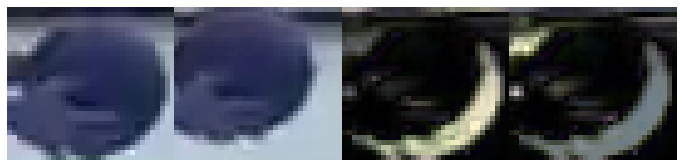

In [52]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import metrics, filters
import cv2
from sklearn.metrics import jaccard_score
from typing import Tuple
import pytictoc

timer = pytictoc.TicToc()

def to_slice(box: Tuple[int,int,int,int]) -> np.s_:
    y,x,w,h = box
    return np.s_[y:y+h, x:x+w]

selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])


video = cv2.VideoCapture("videos/basketball_1_240.mp4")
_, first_frame = video.read()
for _ in range(24):
    _, next_frame = video.read()

def preprocess(im: np.ndarray) -> np.ndarray:
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im / 255
    return (filters.sobel(im) > 0.1).astype('int')


timer.tic()
first_frame = preprocess(first_frame[to_slice(selected_box)])
next_frame = preprocess(next_frame[to_slice(selected_box)])
rs1 = np.abs(np.sqrt(first_frame * next_frame) - next_frame)
rs2 = np.abs(np.sqrt(first_frame * next_frame) - first_frame)
s = np.sum((rs1 - rs2) ** 2)
rs1 = rs1/rs1.max()
rs2 = rs2/rs2.max()
timer.toc()

print(s)

# print(jaccard_score(first_frame, next_frame, average='micro'))

plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(np.hstack([first_frame, next_frame, rs1, rs2]), 'gray')



In [1]:
import numpy as np
import cv2 as cv2
import argparse
import matplotlib.pyplot as plt


def to_slice(box: tuple, height: int, width: int, margin: int) -> np.s_:
    (x, y, w, h) = box
    x = min(max(0, x - margin), width - w)
    y = min(max(0, y - margin), height - h)
    return np.s_[y : y + h, x : x + w]


margin = 20
selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])
# selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])
cap = cv2.VideoCapture("videos/bee_240.mp4")
# take first frame of the video
ret, fframe = cap.read()
# setup initial location of window
y, x, w, h = selected_box
track_window = (x, y, w, h)
# set up the ROI for tracking


def calculcate_probs_image(
    roi: np.ndarray,
    next_frame: np.ndarray,
    track_window: tuple,
    margin: int,
    stride: int = 1,
) -> np.ndarray:
    height, width = next_frame.shape[:2]
    (x, y, w, h) = track_window

    next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    sum_images = np.zeros(next_frame.shape)
    sum_indexes = np.zeros(next_frame.shape) + 1e-7
    
    for j in range(
        max(0, y - margin),
        min(height - h, y + margin),
        stride,
    ):
        for i in range(
            max(0, x - margin),
            min(width - w, x + margin),
            stride,
        ):
            index = np.s_[j:j+h, i:i+w]
            obj = next_frame[index]
            err = obj - roi
            sum_images[index] += err / err.max()
            sum_indexes[index] += 1
    data = (sum_images/ sum_indexes)
    return data


def calculate_histogram_mask(frame: np.ndarray, track_window: tuple, bins=50):
    (x, y, w, h) = track_window
    roi = frame[y : y + h, x : x + w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    roi_hist = cv2.calcHist([hsv_roi], [0], None, [bins], [0, 180], accumulate=False)
    return cv2.normalize(roi_hist, 0, 255, cv2.NORM_MINMAX)


roi_hist = calculate_histogram_mask(fframe, track_window, 50)
roi = fframe[y : y + h, x : x + w]

fframe = cv2.cvtColor(fframe, cv2.COLOR_BGR2GRAY)

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
while 1:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    height, width = frame.shape[:2]
    if ret == True:
        im = np.sqrt((frame * fframe)) - frame
        im = im / im.max()
        # plt.figure(figsize=(16, 8))
        # plt.imshow(im, 'gray')
        # plt.show()
        # break

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(im, track_window, term_crit)

        # roi_hist = calculate_histogram_mask(frame, track_window)

        # Draw it on image
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2)
        roi = frame[y : y + h, x : x + w]
        fframe = frame
        cv2.imshow("img2", img2)
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            break
    else:
        break


cv2.destroyAllWindows()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'meanShift'
> Overload resolution failed:
>  - probImage data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'probImage'


In [37]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pytictoc

timer = pytictoc.TicToc()

margin = 20
term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)
selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])
selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])
y, x, w, h = selected_box
track_window = (x, y, w, h)


def to_slice(box: tuple, height: int, width: int, margin: int) -> np.s_:
    (x, y, w, h) = box
    x = min(max(0, x - margin), width - w)
    y = min(max(0, y - margin), height - h)
    return np.s_[y : y + h, x : x + w]

def get_mask(prev: np.ndarray, next: np.ndarray, track_window, margin=20, dsize = (256, 256)) -> np.ndarray:
    index = to_slice(track_window, next.shape[0], next.shape[1], margin)
    prev_box = prev[index]
    next_box = next[index]
    prev = np.zeros_like(prev)
    next = np.zeros_like(next)
    prev[index] = prev_box
    next[index] = next_box
    
    prev_resized = cv.resize(prev, dsize)
    next_resized = cv.resize(next, dsize)
    flow = cv.calcOpticalFlowFarneback(prev_resized, next_resized, None, 0.5, 5, 9, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    
    hsv = np.zeros((*dsize, 3), dtype='uint8')
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 1] = 255
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    bgr = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
    return cv.resize(bgr, prev.shape[:2][::-1])
    

cap = cv.VideoCapture("videos/basketball_1.mp4")
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
while(1):
    timer.tic()
    ret, frame2 = cap.read()
    he, wi = frame2.shape[:2]
    if not ret:
        print('No frames grabbed!')
        break
    
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    
    bgr = get_mask(prvs, next, track_window)
    
    ret, track_window = cv.meanShift(bgr, track_window, term_crit)
    
    # plt.imshow(next[to_slice(track_window, he, wi, margin)], 'gray')
    # plt.show()
    # plt.imshow(flow[..., 1], 'gray')
    # plt.show()

    (x, y, w, h) = track_window
    img2 = cv.rectangle(frame2, (x, y), (x + w, y + h), 255, 2)
    cv.imshow('frame2', bgr)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png', frame2)
        cv.imwrite('opticalhsv.png', bgr)
    prvs = next

cv.destroyAllWindows()

255
Elapsed time is 0.430441 seconds.


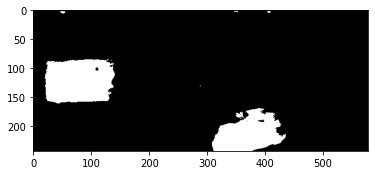

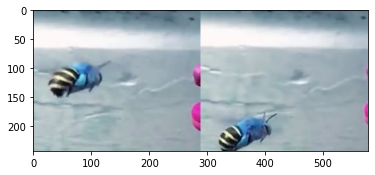

In [41]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import metrics, filters
import cv2
from sklearn.metrics import jaccard_score
from typing import Tuple
import pytictoc
from sklearn import tree
from functools import partial
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
timer = pytictoc.TicToc()

def to_slice(box: tuple, height: int, width: int, margin: int) -> np.s_:
    (y, x, w, h) = box
    x = min(max(0, x - margin), width - w - margin)
    y = min(max(0, y - margin), height - h - margin)
    return np.s_[y : y + h + margin * 2, x : x + w + margin * 2]

def to_mask(box: tuple, height: int, width: int, margin: int) -> np.ndarray:
    (y, x, w, h) = box
    mx = min(x, width - w)
    my = min(y, height - h)
    arr = np.ones((height, width))
    arr[my:my+h, mx:mx+w] = 2

    x = min(max(0, x - margin), width - w - margin)
    y = min(max(0, y - margin), height - h - margin)
    index = np.s_[y : y + h + margin * 2, x : x + w + margin * 2]
    return arr[index]

margin = 85
selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])
selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])

video = cv2.VideoCapture("videos/bee_240.mp4")
_, first_frame = video.read()
# first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY) / 255.0
for _ in range(44):
    _, next_frame = video.read()
    # next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY) / 255.0

print(first_frame.max())
height, width = first_frame.shape[:2]

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                             max_depth=10, max_samples=0.05)

timer.tic()
index = to_slice(selected_box, height, width, margin)
first_frame = first_frame[index]  / 255.0
mask = to_mask(selected_box, height, width, margin)
next_frame = next_frame[index]  / 255.0



sigma_min = 0.5
sigma_max = 15
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=True, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(first_frame)
clf = future.fit_segmenter(mask, features, clf)


result1 = future.predict_segmenter(features, clf)
features2 = features_func(next_frame)
result2 = future.predict_segmenter(features2, clf)
timer.toc()
plt.imshow(np.hstack([result1, result2]), 'gray')
plt.show()
plt.imshow(np.hstack([first_frame, next_frame]))



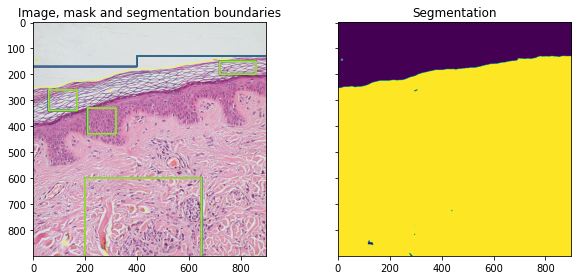

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

full_img = data.skin()

img = full_img[:900, :900]

# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.
training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
training_labels[:130] = 1
training_labels[:170, :400] = 1
training_labels[600:900, 200:650] = 2
training_labels[330:430, 210:320] = 2
training_labels[260:340, 60:170] = 2
training_labels[150:200, 720:860] = 2

sigma_min = 1
sigma_max = 4
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=False,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()